## Lectura de los datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
%matplotlib inline

/home/abarsotti/Programming/VirtualEnv/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Indica si se utilizarán archivos locales del dataset. En caso contrario, se descargarán de enlaces públicos.
USE_LOCAL_FILES = False

In [3]:
PICTURE_SIZE = 64
CHANNELS = 'RGB'
INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend([f'{color}{i}' for i in range(PICTURE_SIZE ** 2)])

In [4]:
NCOLS = 5
NROWS = 3
TITLE_PLOT_FONT_SIZE = 18

In [5]:
def show_images(samples, main_title, with_predictions=False):
    plt.figure(figsize=(16, 8))
    plt.tight_layout()
    plt.suptitle(main_title, fontsize=TITLE_PLOT_FONT_SIZE)
    plt.subplots_adjust(hspace=0.4)
    grid_index = 0
    
    for index, sample in samples.iterrows():
        if with_predictions:
            title_text = f"{sample['prediction']}: {sample['prediction_confidence']:.5f}%\n[{sample['fruit']}]" 
        else:
            title_text = sample['fruit']
        
        grid_index += 1
        plt.subplot(NROWS, NCOLS, grid_index)
        
        plt.title(title_text)

        sample_as_grid = sample[INPUT_COLUMNS].values.reshape(len(CHANNELS), PICTURE_SIZE, PICTURE_SIZE).astype(np.float)
            
        sample_as_grid = np.transpose(sample_as_grid) / 255
        
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

    plt.show()

In [6]:
if USE_LOCAL_FILES:
    train = pd.read_csv('data/training.tar.xz', compression='xz')
    test = pd.read_csv('data/validation.tar.xz', compression='xz')
else:
    train_url = 'https://uce21a75610408aef36b22e4cb3c.dl.dropboxusercontent.com/cd/0/get/AIVGqDXN23lYO9FLSFwB98s9itiMzGs1iFufh7dQ-eEt4y_pD2j_8IrkpByQyqNPKpdbbOEPdBf5ps1PAx5D5lPe9r14E7Rn1tidmhzLCTJwGqo455SssmZQfBIgjj4eTKIsCsz31JfHO8_OFn1OhX6bS8xXSucKR7bj64U69l5H19OoZIxjisDnqPz2CxtoPG0/file?_download_id=71288272593405581818084505739512367494333417574589728615114206607&_notify_domain=www.dropbox.com&dl=1'
    test_url = 'https://drive.google.com/uc?authuser=0&id=1oySjRENV-vJCkvG_RIzcY_CMG5BrPZ6r&export=download'
    train = pd.read_csv(train_url, compression='xz')
    test = pd.read_csv(test_url, compression='xz')

train.rename(columns={'training.csv': 'R0', 'label': 'fruit'}, inplace=True)
test.rename(columns={'validation.csv': 'R0', 'label': 'fruit'}, inplace=True)

In [7]:
sets = (
    ('Train', train),
    ('Test', test),
)

## Variables

Las variables de entrada del dataset utilizado expresan la información de color de cada pixel de una imagen de una fruta. Dado que las imágenes tienen una dimensión de 64 x 64 píxeles, se tienen 4096 variables por cada canal de color. Los nombres de estas variables consisten en una letra que representa el canal de color y un número que indica su índice con base 0.

Además, se tiene la variable de salida "fruit" que corresponde al nombre de la fruta en cuestión.

## Etiquetas posibles

In [8]:
FRUITS = sorted(train.fruit.unique())
print(f'Existen {len(FRUITS)} etiquetas posibles en el dataset utilizado:')
for fruit1, fruit2 in zip(FRUITS[:len(FRUITS)//2], FRUITS[len(FRUITS)//2:]):
    print(f'  - {fruit1: <30}- {fruit2}')

Existen 64 etiquetas posibles en el dataset utilizado:
  - Apple Braeburn                - Huckleberry
  - Apple Golden 1                - Kaki
  - Apple Golden 2                - Kiwi
  - Apple Golden 3                - Kumquats
  - Apple Granny Smith            - Lemon
  - Apple Red 1                   - Lemon Meyer
  - Apple Red 2                   - Limes
  - Apple Red 3                   - Litchi
  - Apple Red Delicious           - Mandarine
  - Apple Red Yellow              - Mango
  - Apricot                       - Maracuja
  - Avocado                       - Nectarine
  - Avocado ripe                  - Orange
  - Banana                        - Papaya
  - Banana Red                    - Passion Fruit
  - Cactus fruit                  - Peach
  - Cantaloupe 1                  - Peach Flat
  - Cantaloupe 2                  - Pear
  - Carambula                     - Pear Abate
  - Cherry 1                      - Pear Monster
  - Cherry 2                      - Pear Williams
  - 

## Ejemplos de imágenes del dataset

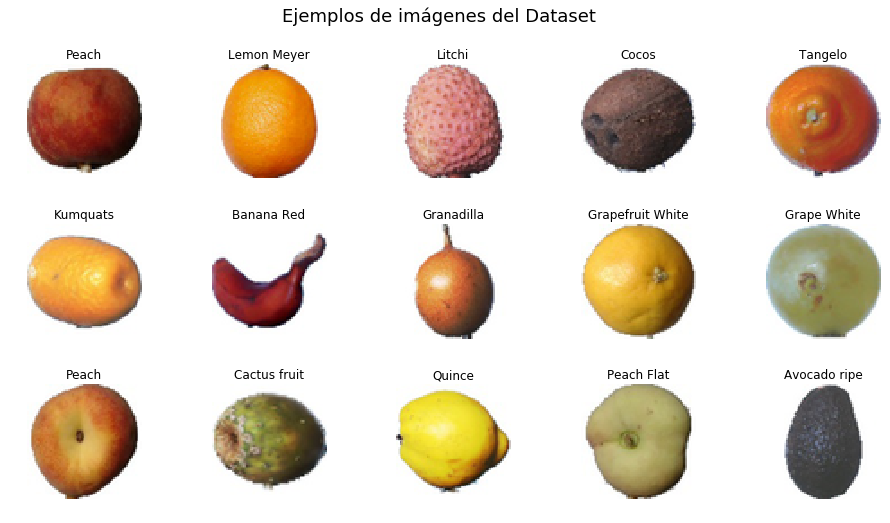

In [9]:
show_images(main_title='Ejemplos de imágenes del Dataset', samples=train.sample(NROWS*NCOLS))

## Volumetría de los datos

### Training

In [10]:
train.shape

(31688, 12290)

In [11]:
train

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,B4088,B4089,B4090,B4091,B4092,B4093,B4094,B4095,fruit,path
0,255,255,255,255,255,255,254,251,253,254,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
2,251,255,255,255,252,249,251,254,255,253,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
3,255,250,251,255,255,254,253,254,255,245,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
4,253,250,253,255,255,253,253,255,255,251,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
5,255,252,248,249,254,255,255,253,251,250,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
6,254,254,254,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
7,255,255,252,251,254,255,255,254,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
8,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
9,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...


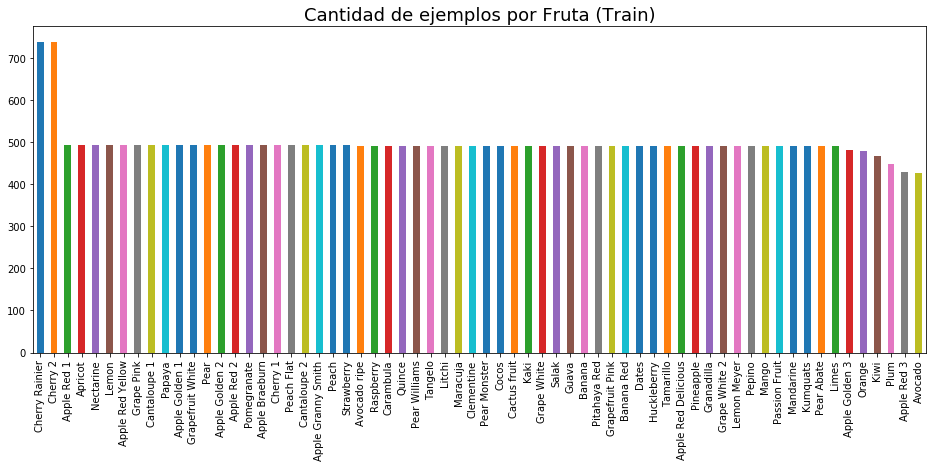

In [12]:
train.fruit.value_counts().plot.bar(figsize=(16,6))
plt.title('Cantidad de ejemplos por Fruta (Train)', fontsize=TITLE_PLOT_FONT_SIZE);

### Test

In [13]:
test.shape

(10657, 12290)

In [14]:
test

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,B4088,B4089,B4090,B4091,B4092,B4093,B4094,B4095,fruit,path
0,252,254,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
3,255,255,255,255,254,254,254,254,254,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
5,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
6,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
7,255,249,248,255,255,254,251,254,255,252,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
8,255,255,253,251,251,253,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...
9,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Valid...


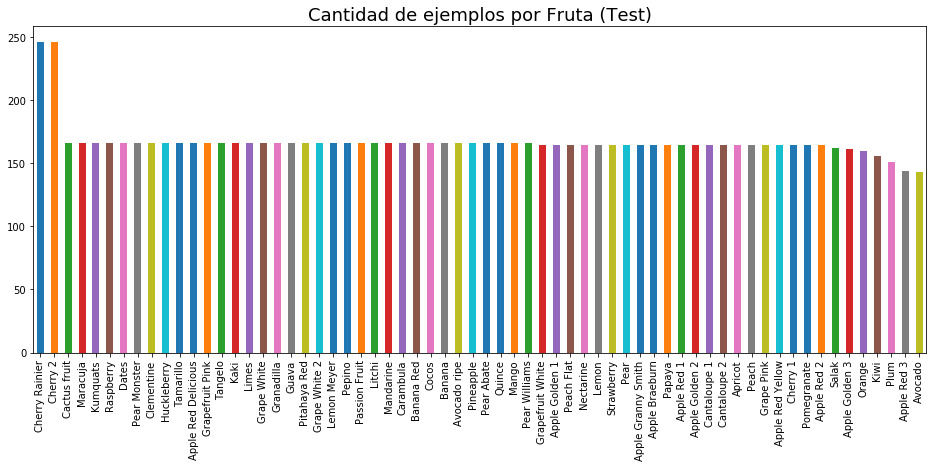

In [15]:
test.fruit.value_counts().plot.bar(figsize=(16,6))
plt.title('Cantidad de ejemplos por Fruta (Test)', fontsize=TITLE_PLOT_FONT_SIZE);

# Redes Neuronales

## Funciones

In [16]:
''' Extrae las columnas utilizadas como entrada para los modelos a entrenar. '''
def extract_inputs(dataset, convolutional=False):
    if not convolutional:
        return dataset[INPUT_COLUMNS].values / 255
    else:
        return dataset[INPUT_COLUMNS].values.reshape(len(dataset),
                    PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255

''' Extrae la columna utilizada como salida para los modelos a entrenar. '''
def extract_outputs(dataset):
    is_fruit_columns = [(dataset.fruit == fruit).values for fruit in FRUITS]
    return np.array(is_fruit_columns).T

In [17]:
'''Agrega tres columnas:
    - "prediction" con la predicción realizada por el modelo.
    - "prediction_confidence" con el valor devuelto por el modelo para dicha predicción.
    - "correct" indica si la predicción es correcta.'''
def add_predictions(dataset, model, convolutional=False):
    predictions = model.predict(extract_inputs(dataset, convolutional=convolutional))

    for fruit_number, fruit in enumerate(FRUITS):
        dataset[fruit] = predictions[:, fruit_number]
    
    dataset['prediction'] = dataset[FRUITS].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[FRUITS].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.fruit

## Red neuronal tradicional

In [18]:
nn_model = Sequential([
    Dense(500, activation='relu', input_shape=(len(INPUT_COLUMNS), )),
        
    Dense(250, activation='relu'),
        
    Dense(100, activation='relu'),
        
    Dense(len(FRUITS), activation='softmax'),
])

nn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [19]:
nn_history = nn_model.fit(
    extract_inputs(train),
    extract_outputs(train),
    epochs=5,
    batch_size=160,
    validation_data=(
        extract_inputs(test),
        extract_outputs(test),
    )
)

Train on 31688 samples, validate on 10657 samples
Epoch 1/5
31688/31688 [==============================] - 20s 621us/step - loss: 2.6148 - acc: 0.3374 - val_loss: 1.3703 - val_acc: 0.5950
Epoch 2/5
31688/31688 [==============================] - 19s 603us/step - loss: 0.5201 - acc: 0.8467 - val_loss: 0.6925 - val_acc: 0.7915
Epoch 3/5
31688/31688 [==============================] - 19s 606us/step - loss: 0.1707 - acc: 0.9528 - val_loss: 0.4948 - val_acc: 0.8472
Epoch 4/5
31688/31688 [==============================] - 19s 604us/step - loss: 0.1048 - acc: 0.9708 - val_loss: 0.3980 - val_acc: 0.8840
Epoch 5/5
31688/31688 [==============================] - 19s 605us/step - loss: 0.0501 - acc: 0.9857 - val_loss: 0.2832 - val_acc: 0.9104


### Accuracy a lo largo del entrenamiento

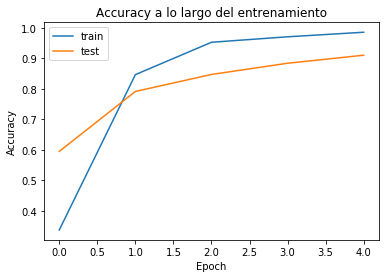

In [20]:
plt.plot(nn_history.history['acc'], label='train')
plt.plot(nn_history.history['val_acc'], label='test')
plt.title('Accuracy a lo largo del entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show();

### Matrices de confusión

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.98283
Precision: 0.98785
Recall: 0.98271


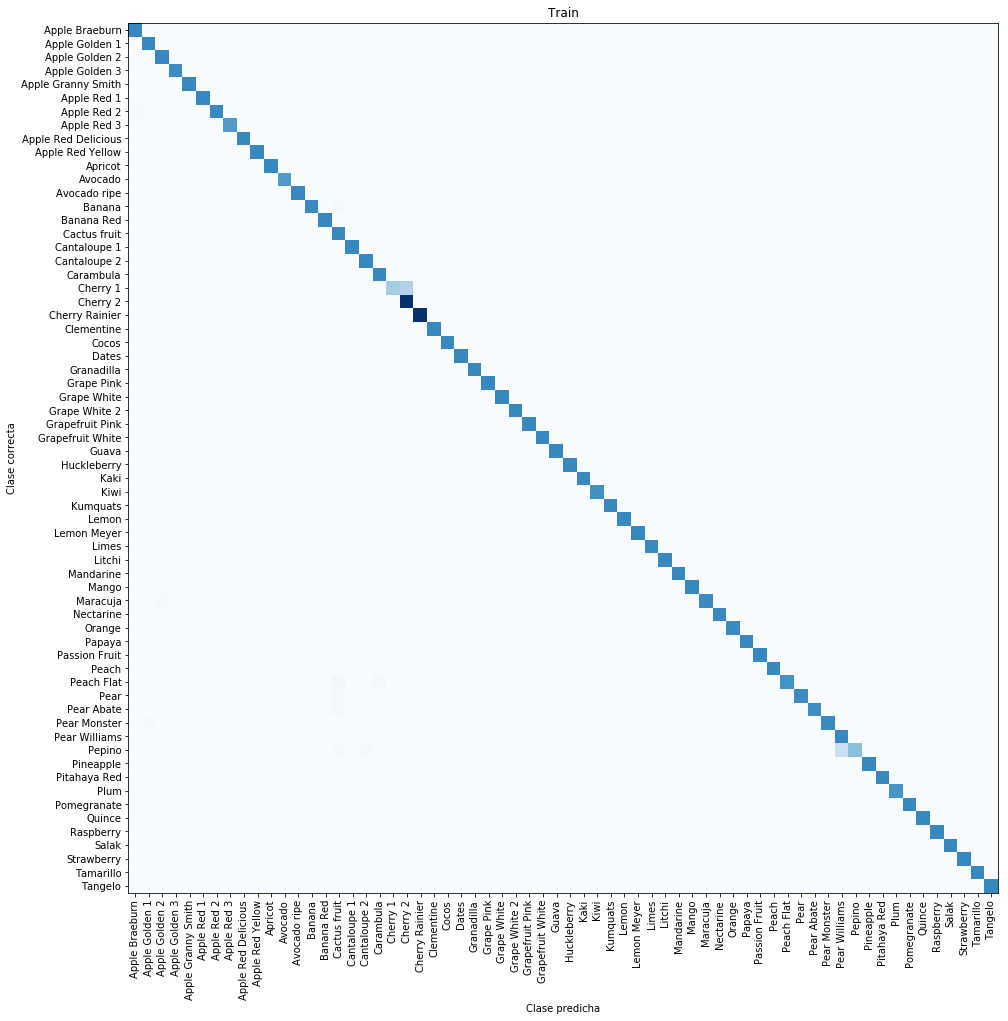

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.91039
Precision: 0.92239
Recall: 0.91001


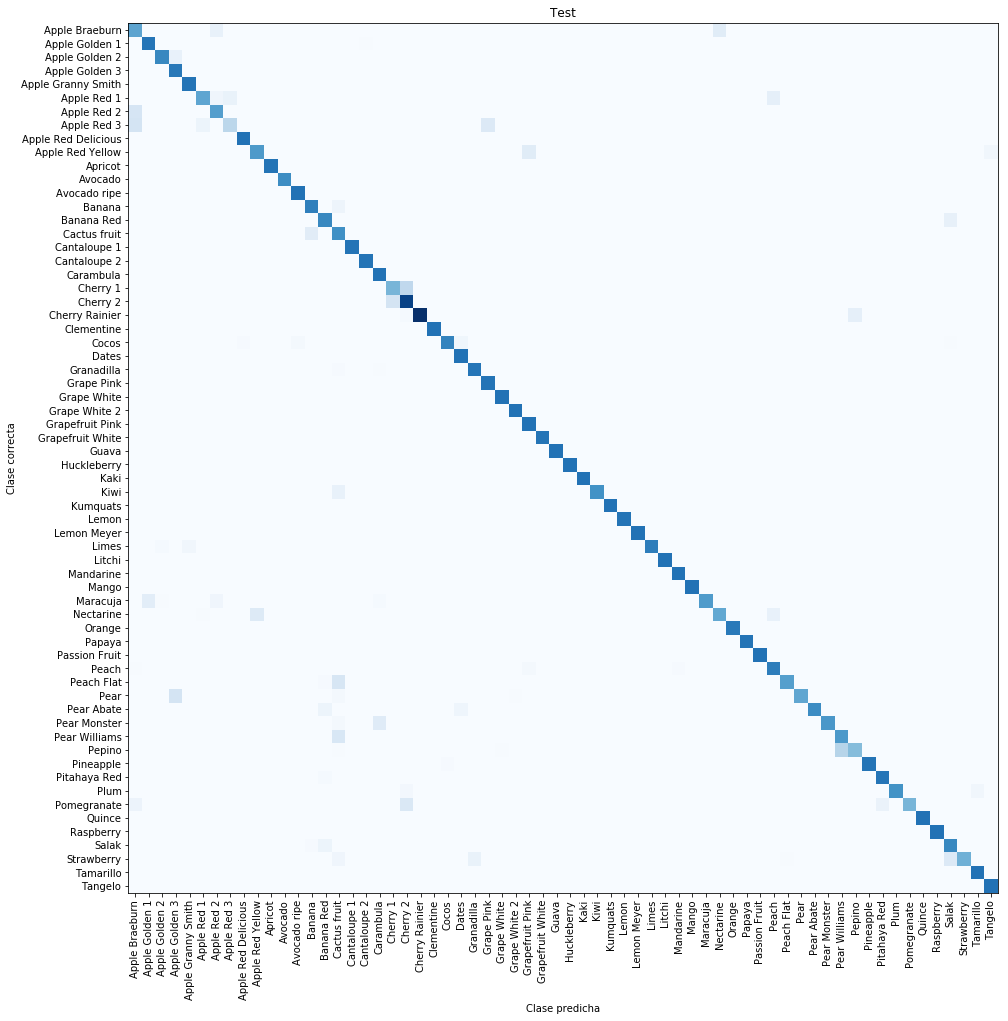

In [21]:
for set_name, set_data in sets:
    add_predictions(set_data, nn_model)
    
    print(f'{set_name:-^115}')
    print(f'Accuracy: {accuracy_score(set_data.fruit, set_data.prediction):.5f}')
    print(f'Precision: {precision_score(set_data.fruit, set_data.prediction, average="macro"):.5f}')
    print(f'Recall: {recall_score(set_data.fruit, set_data.prediction, average="macro"):.5f}')

      
    plt.figure(figsize=(16,16))
    plt.xticks([x for x in range(len(FRUITS))], FRUITS, rotation=90)
    plt.yticks([x for x in range(len(FRUITS))], FRUITS)
    plt.xlabel('Clase predicha')
    plt.ylabel('Clase correcta')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.fruit, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

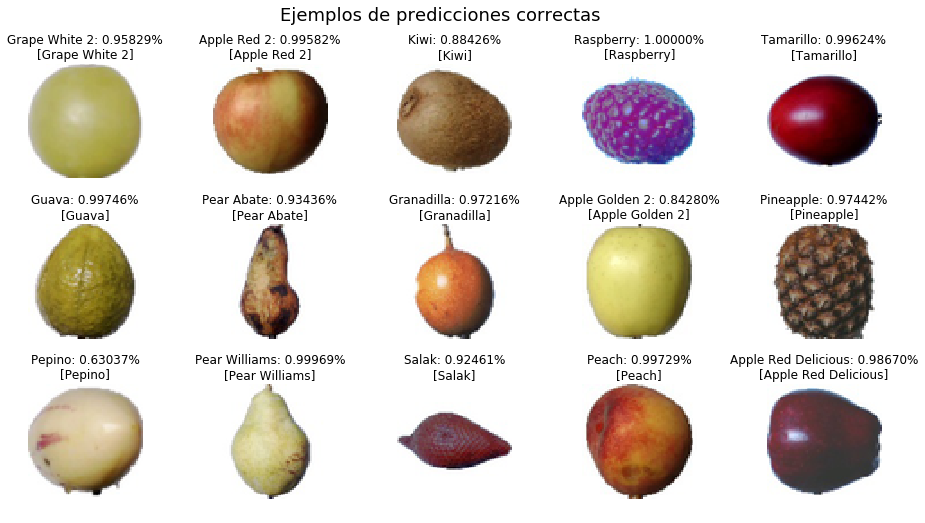

In [22]:
show_images(test[test.fruit == test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Ejemplos de predicciones correctas')

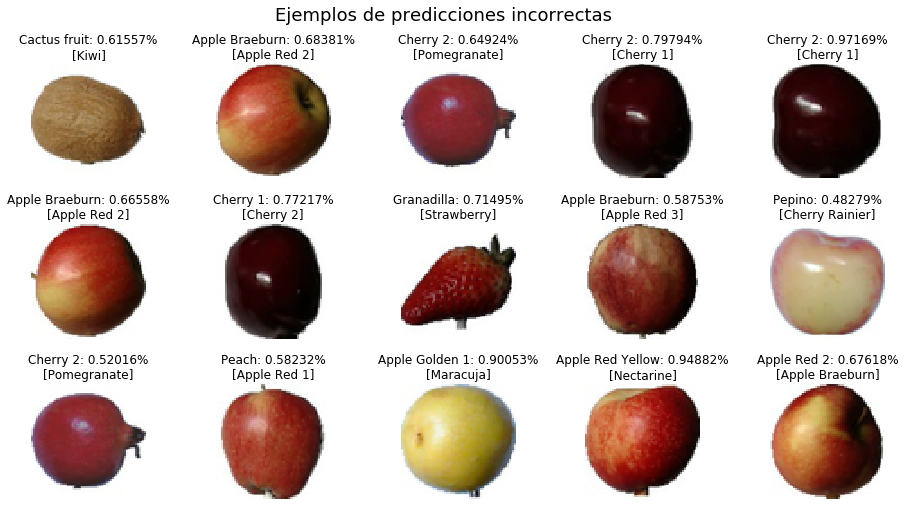

In [23]:
show_images(test[test.fruit != test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Ejemplos de predicciones incorrectas')

## Red neuronal convolucional

In [24]:
cnn_model = Sequential([
    Convolution2D(16, (4, 4), activation='relu', input_shape=(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)),),
        
    MaxPooling2D(pool_size=(2, 2)),
            
    Convolution2D(8, (4, 4), activation='relu'),
        
    MaxPooling2D(pool_size=(2, 2)),
        
    Convolution2D(4, (4, 4), activation='relu'),
       
    Flatten(),
    
    Dense(256, activation='relu'),
        
    Dense(128, activation='relu'),
        
    Dense(len(FRUITS), activation='softmax'),
])


cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [25]:
cnn_history = cnn_model.fit(
    extract_inputs(train, convolutional=True),
    extract_outputs(train),
    epochs=5,
    batch_size=160,
    validation_data=(
        extract_inputs(test, convolutional=True),
        extract_outputs(test),
    )
)

Train on 31688 samples, validate on 10657 samples
Epoch 1/5
31688/31688 [==============================] - 21s 653us/step - loss: 1.3870 - acc: 0.6231 - val_loss: 0.7185 - val_acc: 0.7683
Epoch 2/5
31688/31688 [==============================] - 20s 617us/step - loss: 0.2321 - acc: 0.9303 - val_loss: 0.3395 - val_acc: 0.9069
Epoch 3/5
31688/31688 [==============================] - 20s 627us/step - loss: 0.1148 - acc: 0.9690 - val_loss: 0.2936 - val_acc: 0.9100
Epoch 4/5
31688/31688 [==============================] - 21s 650us/step - loss: 0.0568 - acc: 0.9837 - val_loss: 0.3134 - val_acc: 0.9171
Epoch 5/5
31688/31688 [==============================] - 21s 661us/step - loss: 0.0564 - acc: 0.9840 - val_loss: 0.2232 - val_acc: 0.9417


### Accuracy a lo largo del entrenamiento

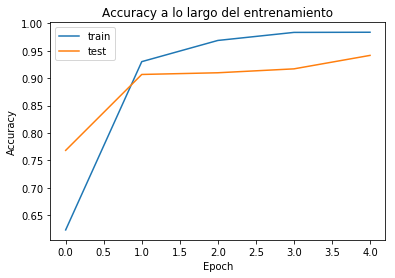

In [26]:
plt.plot(cnn_history.history['acc'], label='train')
plt.plot(cnn_history.history['val_acc'], label='test')
plt.title('Accuracy a lo largo del entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show();

### Matrices de confusión

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.99198
Precision: 0.99319
Recall: 0.99285


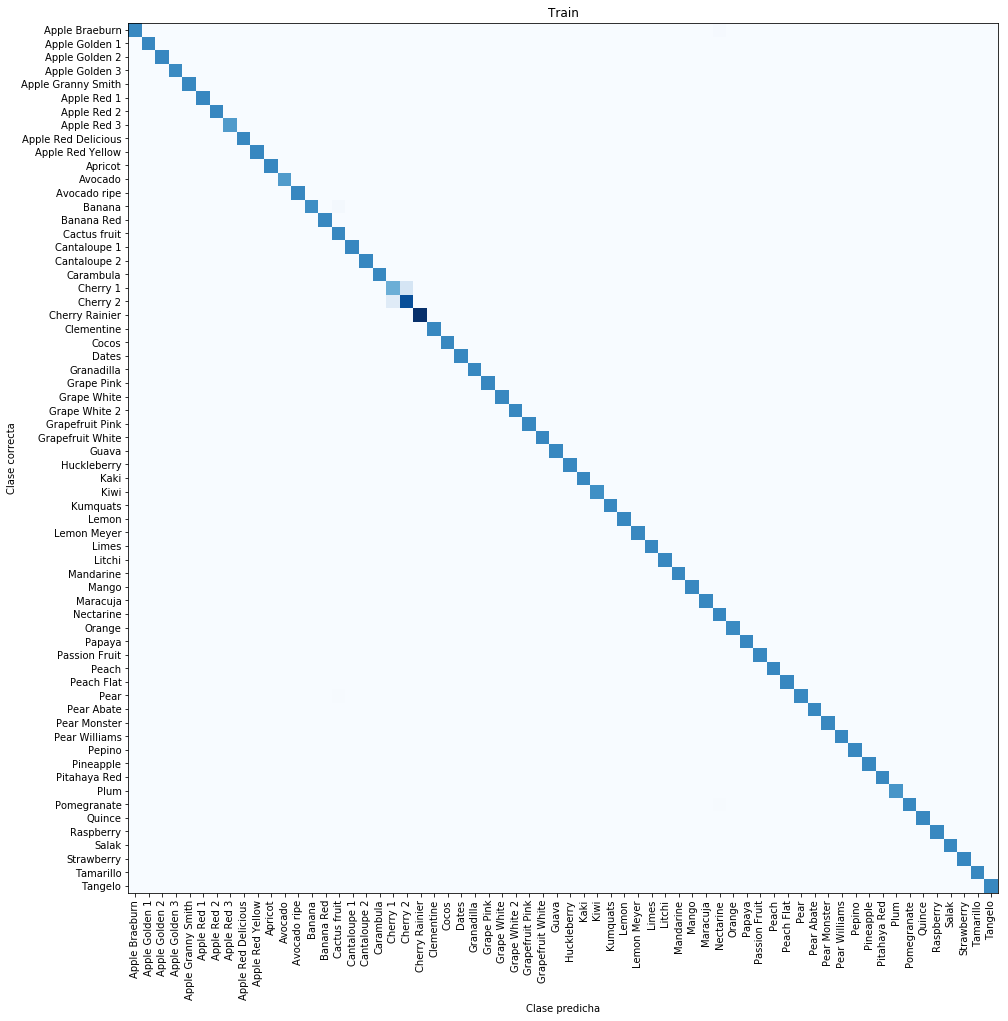

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.94173
Precision: 0.94998
Recall: 0.94311


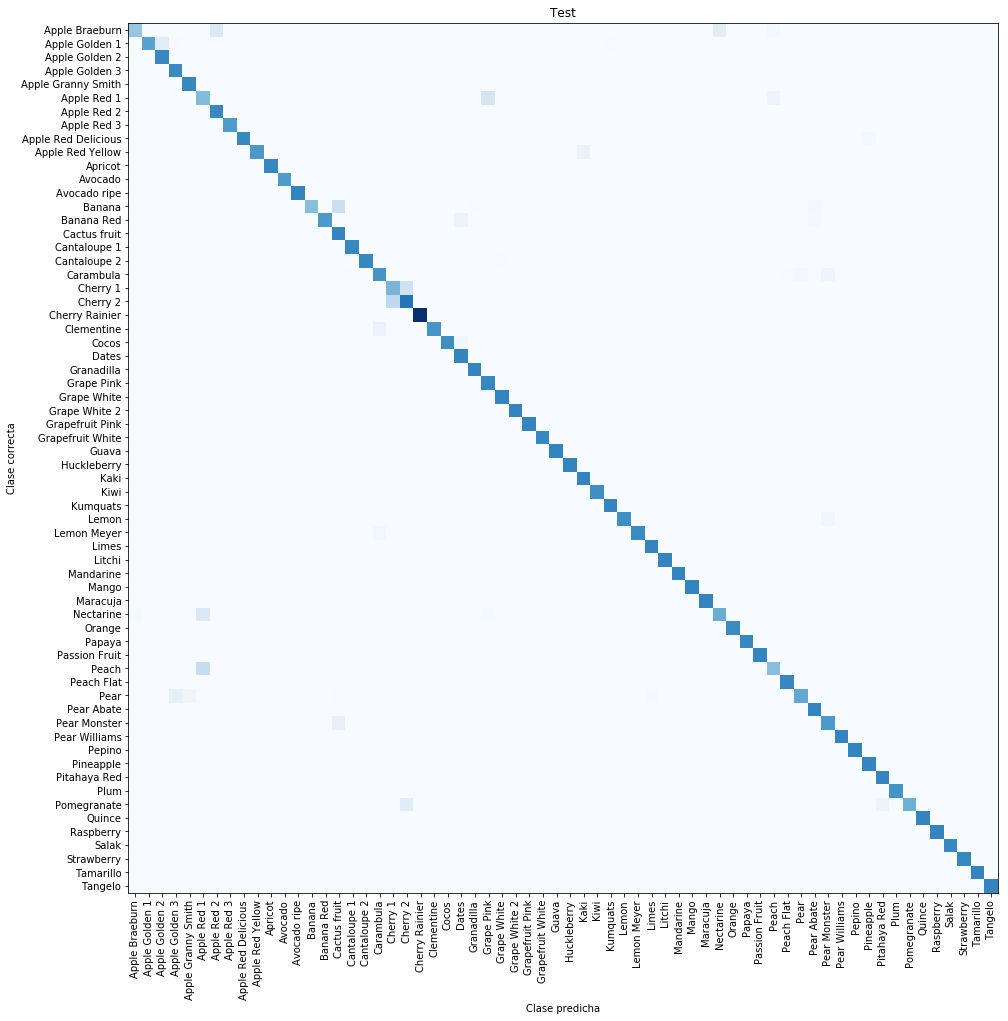

In [27]:
for set_name, set_data in sets:
    add_predictions(set_data, cnn_model, convolutional=True)
    
    print(f'{set_name:-^115}')
    print(f'Accuracy: {accuracy_score(set_data.fruit, set_data.prediction):.5f}')
    print(f'Precision: {precision_score(set_data.fruit, set_data.prediction, average="macro"):.5f}')
    print(f'Recall: {recall_score(set_data.fruit, set_data.prediction, average="macro"):.5f}')

      
    plt.figure(figsize=(16,16))
    plt.xticks([x for x in range(len(FRUITS))], FRUITS, rotation=90)
    plt.yticks([x for x in range(len(FRUITS))], FRUITS)
    plt.xlabel('Clase predicha')
    plt.ylabel('Clase correcta')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.fruit, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

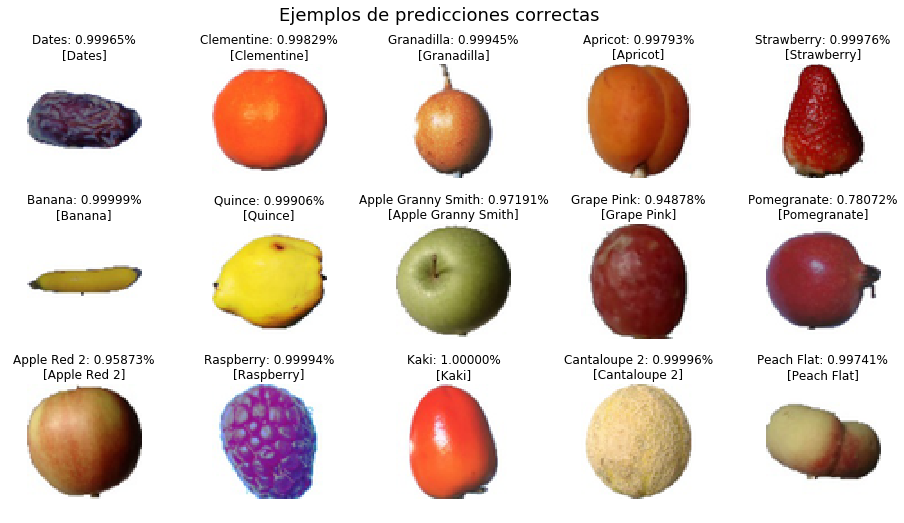

In [28]:
show_images(test[test.fruit == test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Ejemplos de predicciones correctas')

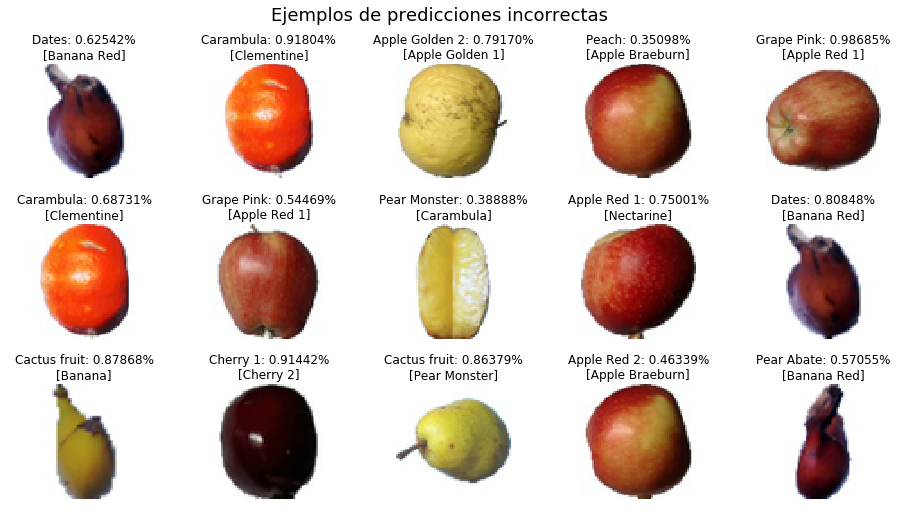

In [29]:
show_images(test[test.fruit != test.prediction].sample(NROWS*NCOLS), with_predictions=True, main_title='Ejemplos de predicciones incorrectas')